In [1]:
# pylint: disable-all
main_path = 'e:\\ehz'
import sys
import os
sys.path.append(main_path)
sys.path.append('e:\\stripping\KR_example-main\src')
os.chdir(main_path)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc = { 'figure.figsize': (15, 5) })


import utils

In [2]:
import plotly.express as px
bonds=utils.get_bonds()
sub_folder='OTR'
E=pd.read_csv(f'data/US_TREAS_CURVE/{sub_folder}/errors.csv', index_col=0, parse_dates=True)
AGG_E= E.T.groupby(lambda x: bonds.loc[x, 'length']if x !='1D' else 0).sum().T
AGG_E['MAE']=AGG_E.abs().mean(axis=1)
AGG_E['MAX']=AGG_E.abs().max(axis=1)
px.line(AGG_E[['MAE', 'MAX']])

In [116]:
from xbbg import blp

tickers = []
for i in np.arange(1, 12, 0.25):
    tickers.append(f'FNCL {i} N Mtge')
 
tickers_names = blp.bdp(tickers, ['name', 'issue_dt', 'px_mid']).dropna()


tickers_names['coupon'] = tickers_names['name'].apply(lambda x : float(x.split(' ')[1]))
tickers_names.sort_values(by = 'coupon', inplace=True)

tickers = tickers_names.index

In [118]:
tickers = list(tickers)

In [136]:
df = pd.read_csv('data/mbs.csv', index_col=0, parse_dates=True)

<AxesSubplot:>

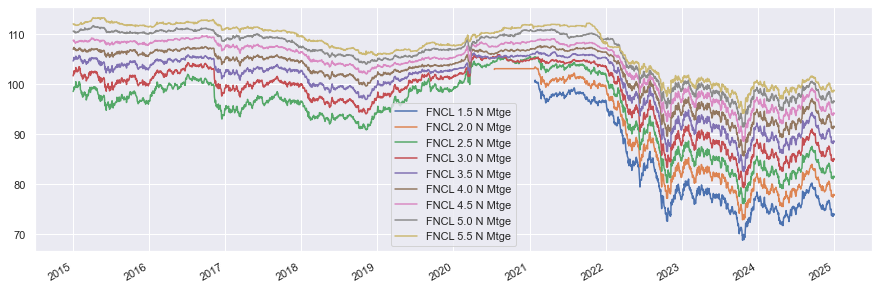

In [137]:
df.plot()

In [138]:
#df = pd.DataFrame()
debut = df.index[0] #pd.to_datetime('01/01/2005')
end = df.index[-1] #pd.Timestamp.today() + pd.offsets.BDay(-1, normalize=True)

In [150]:
fanni = []

In [151]:
i1 = -1
#tickers[i1]

debut = pd.to_datetime('01/01/2010')
end = pd.to_datetime('01/01/2015') - pd.offsets.BDay()

In [152]:
for i, ticker in enumerate(tickers): 
    if i<= i1 : 
        continue
    try : 
        print(ticker)
        col = blp.bdh(tickers=ticker,
                        flds='px_mid',
                        start_date=debut,
                        end_date=end,
                        Per='D',
                        calendarCodeOverride= 'US') 
        fanni.append(col)

    except ValueError :
        print (ticker, ' errored')

FNCL 1.5 N Mtge
FNCL 2.0 N Mtge
FNCL 2.5 N Mtge
FNCL 3.0 N Mtge
FNCL 3.5 N Mtge
FNCL 4.0 N Mtge
FNCL 4.5 N Mtge
FNCL 5.0 N Mtge
FNCL 5.5 N Mtge
FNCL 6.0 N Mtge
FNCL 6.5 N Mtge
FNCL 7.0 N Mtge
FNCL 7.5 N Mtge


In [154]:
update = pd.concat(fanni, axis=1)
update = update.droplevel(level=1,axis=1)
update.index=update.index.to_series().apply(pd.to_datetime)

<AxesSubplot:>

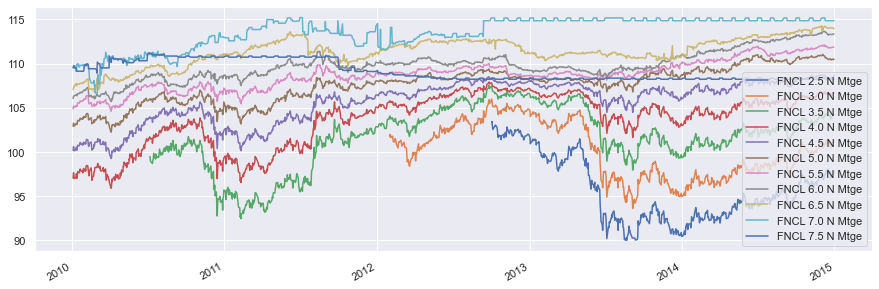

In [155]:
update.plot()

In [157]:
update.index[-1], df.index[0]

(Timestamp('2014-12-31 00:00:00'), Timestamp('2015-01-02 00:00:00'))

In [158]:
df = pd.concat((df, update), axis=0)

In [160]:
df.to_csv('data/mbs.csv')

In this notebook, we provide an example of using the kernel ridge (KR) regression model for discount curve estimation using U.S. Treasury data. This notebook runs on Google Colab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps 
import time
import sys
import os

### download KR example files from Github
if not os.path.exists('KR_example'):
  !git clone https://github.com/yye9701/KR_example.git
dir_kr = './KR_example/'

sys.path.append(dir_kr+'src/')
import kr_model
import kr_utils


# Generating kernel matrix
KR has three hyper-parameters: $\alpha$, $\delta$, and $\lambda$, among which $\alpha$ and $\delta$ are shape hyper-parameters that determine the kernel matrix. For a fixed pair of $\alpha$ and $\delta$, we need to generate a kernel matrix only once, which can be shared across multiple cross-sections. $\lambda$ controls the degree of smoothness and model complexity. Baseline values for these three hyper-parameters are $\alpha=0.05$, $\delta=0$, and $\lambda=1$.

In this example, we generate a kernel matrix of dimension $N$-by-$N$, where $N$ is the maximum time-to-maturity of the discount curve that we are about to estimate. $N$ needs to be no less than the maximum time-to-maturity in days $N'$ of securities in the data so that pricing error can be calculated. When $N>N'$, we also obtain extrapolated curve estimates.

In [2]:
### settings
# kernel hyper-parameters
alpha=0.05
delta=0.00

# max time to maturity in days
N=30*365

start_time=time.time()
K=kr_model.generate_kernel_matrix(alpha, delta, N, N)
end_time=time.time()

print('Time elapsed for generating a {}-by-{} kernel matrix with alpha = {} and delta = {}: {:.1f} sec'\
      .format(N,N,alpha, delta, end_time-start_time))

Time elapsed for generating a 10950-by-10950 kernel matrix with alpha = 0.05 and delta = 0.0: 11.6 sec


# Load data

Price and cashflow data are contained in vector $B$ of dimension $M$ and matrix $C$ of dimension $M$-by-$N'$. $M$ is the number of securities in the cross-section. $N'$ is the maximum time-to-maturity in days of the data. For example, assume that there are three securities with prices 0.99, 0.98, and 0.97 maturing in 1, 3, and 5 days. Each of these securities has only one cash flow with value 1 due at maturity. Then, $B$ and $C$ take the following form:

$$B =
\begin{pmatrix}
0.99\\
0.98\\
0.97
\end{pmatrix}, 
$$

$$
C = 
\begin{pmatrix}
1 & 0 & 0 & 0& 0\\
0 & 0 & 1 & 0& 0\\
0 & 0 & 0 & 0& 1\\
\end{pmatrix}.
$$

In this example, $M=3$ and $N'=5$.

In the code block below, we load price vectors and cashflow matrices on two example dates: 1961-06-30 and 2013-12-31. We also calculate yield-to-maturity (YTM) and duration of observations so that we can compute weight vector $\omega$, which is used for weighing individual securities.

In [3]:
### load example data
dir_data=dir_kr+'example_data/'
example_dates=['1961-06-30', '2013-12-31']

start_time=time.time()

dict_data={}
for date in example_dates:
    # load price vector and cashflow matrix
    B=np.load(dir_data+'price_{}.npy'.format(date))
    C=sps.load_npz(dir_data+'cashflow_{}.npz'.format(date)).toarray()
    M=B.shape[0]
    
    print('Date: {}; Number of securities: {}'.format(date, M))
    
    # get YTM and duration
    ytm, dur=np.zeros(M), np.zeros(M) # YTM and duration
    ttm = np.zeros(M) # time to maturity in days
    for i in range(M):
        time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
        ytm[i], dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
        ttm[i] = max(time_to_cashflow_inday)

    # get inverse of weights for fitting
    # weights w is computed as w=1/inv_w
    inv_w=(dur*B)**2*M
    
    dict_data[date]={'B':B, 'C':C, 'ytm':ytm, 'dur':dur, 'ttm':ttm, 'inv_w':inv_w}
    
end_time=time.time()

print('Time elapsed for loading and preparing data for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Date: 1961-06-30; Number of securities: 50
Date: 2013-12-31; Number of securities: 280
Time elapsed for loading and preparing data for 2 example dates: 0.5 sec


### Visualizing price data on example dates

In the plots below, we scatter prices and implied yield-to-maturity against time-to-maturity of securities in the example data. 

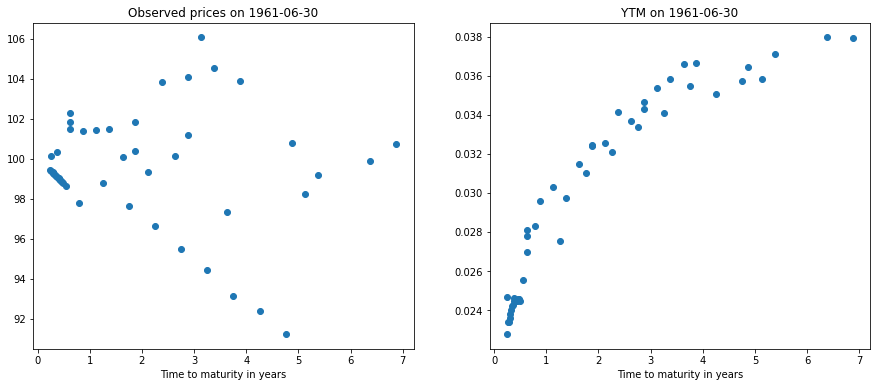

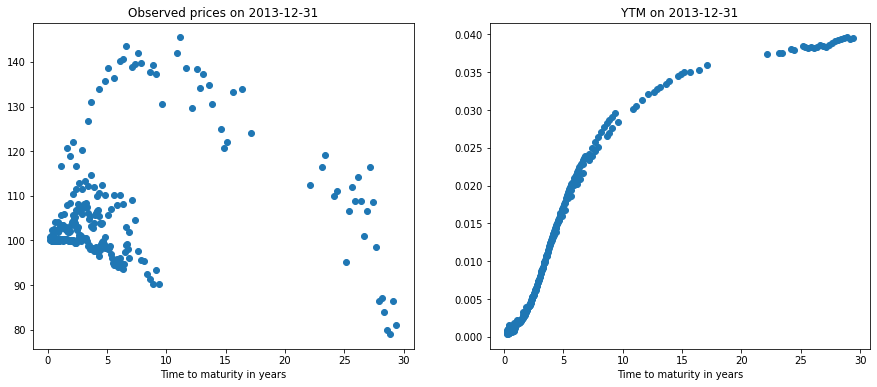

In [9]:
for date in example_dates:

    B=dict_data[date]['B']
    ttm=dict_data[date]['ttm']
    ytm=dict_data[date]['ytm']

    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    
    ax_1.scatter(ttm/365, B)
    ax_2.scatter(ttm/365, ytm)
    
    ax_1.set_title('Observed prices on {}'.format(date))
    ax_2.set_title('YTM on {}'.format(date))
    
    for ax in [ax_1, ax_2]:
        ax.set_xlabel('Time to maturity in years');

### Visualizing cashflow matrices on example dates

We visualize cashflow matrices on example dates in the following code block. The horizontal axis corresponds to time to cashflow in years, and the vertical axis shows indexes of securities on each example date. Intensity of color corresponds to the amount of cashflow payment. 

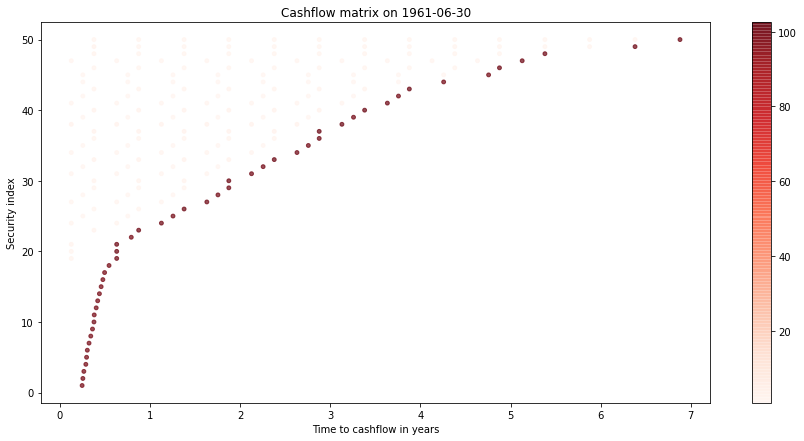

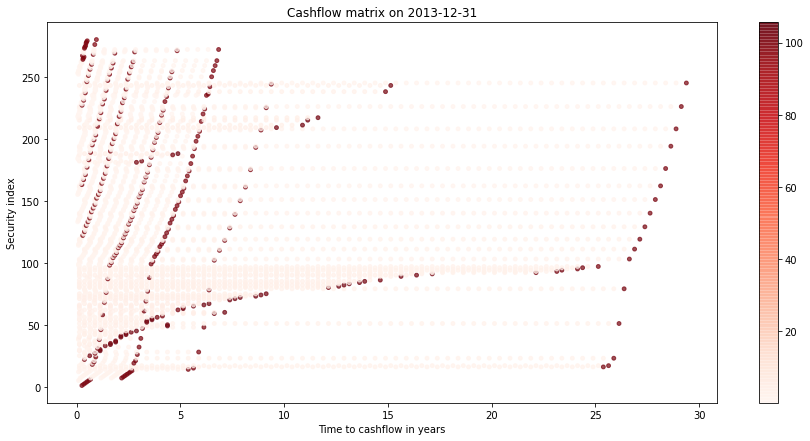

In [5]:
for date in example_dates:

    B=dict_data[date]['B']
    C=dict_data[date]['C']
    M=B.shape[0]

    time_to_cashflow_inday=[]
    for i in range(M):
        time_to_cashflow_inday.append(np.where(C[i]!=0)[0]+1)

    xs=np.concatenate(time_to_cashflow_inday)
    ys=np.concatenate([i* np.ones(time_to_cashflow_inday[i].shape) for i in range(M)])
    color=np.concatenate([C[i, time_to_cashflow_inday[i]-1] for i in range(M)])


    fig=plt.figure(figsize=(15,7))
    ax=fig.add_subplot(1,1,1)
    im = ax.scatter(x=xs/365, y=1+ys, c=color, cmap='Reds', alpha=0.7, s=15)
    fig.colorbar(im,ax=ax)


    ax.set_xlabel('Time to cashflow in years');
    ax.set_ylabel('Security index');
    ax.set_title('Cashflow matrix on {}'.format(date));


# Fit KR model on example dates

Once we've generated the kernel matrix and formatted input data, fitting KR is fast. The KR function returns fitted discount curve and log yield curve. 

In [6]:
### fit KR model on example dates

# KR ridge penalty term 
ridge=1

start_time=time.time()

dict_fit={}
for date in example_dates:
    
    dict_fit[date]=kr_model.KR(C=dict_data[date]['C'], # cashflow matrix
                         B=dict_data[date]['B'], # price vector
                         ridge=ridge, # ridge hyper-parameter
                         inv_w=dict_data[date]['inv_w'], # inverse of the weighting vector
                         K=K # kernel matrix
                        )
                               
end_time=time.time()

print('Time elapsed for fitting KR model for {} example dates: {:.1f} sec'\
      .format(len(example_dates),end_time-start_time))

Time elapsed for fitting KR model for 2 example dates: 0.1 sec


# Plot fitted curves

The code block below plots fitted discount curve and yield curve up to the maximum time-to-maturity $N'$ in the data. 

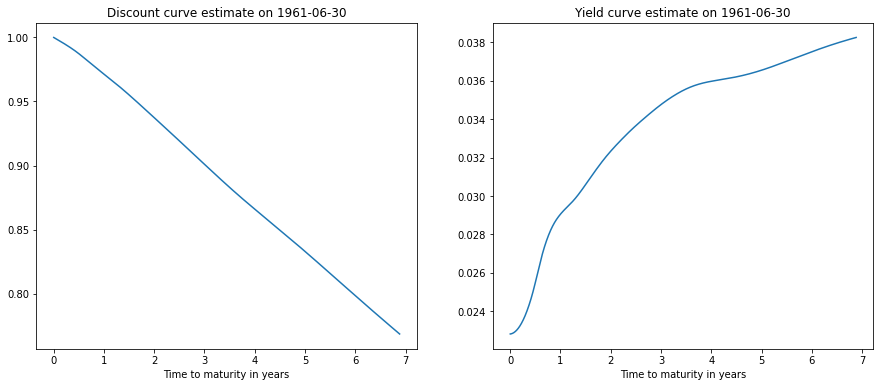

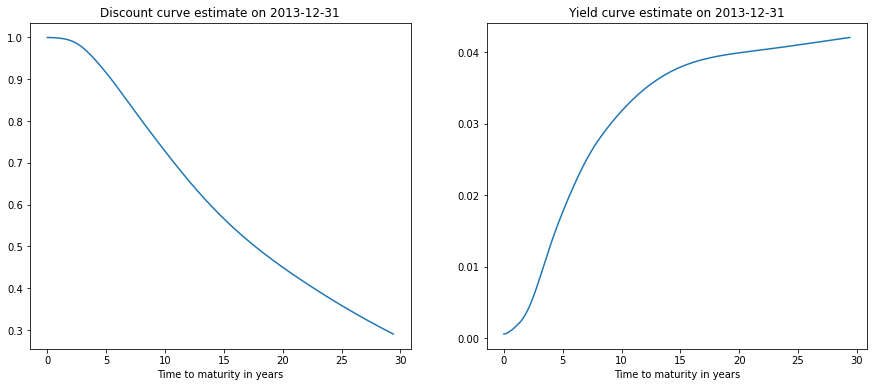

In [7]:
### plot fitted curves up to N'

for date in example_dates:
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    
    max_ttm = int(max(dict_data[date]['ttm']))
    
    ax_1.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['g_solved'][:max_ttm])
    ax_2.plot(np.arange(1,1+max_ttm)/365, dict_fit[date]['y_solved'][:max_ttm])
    
    ax_1.set_title('Discount curve estimate on {}'.format(date))
    ax_2.set_title('Yield curve estimate on {}'.format(date))
    
    for ax in [ax_1, ax_2]:
        ax.set_xlabel('Time to maturity in years');

# Plot fitted yield-to-maturity (YTM)

The code block below plots YTM implied by observed prices and model-implied prices.

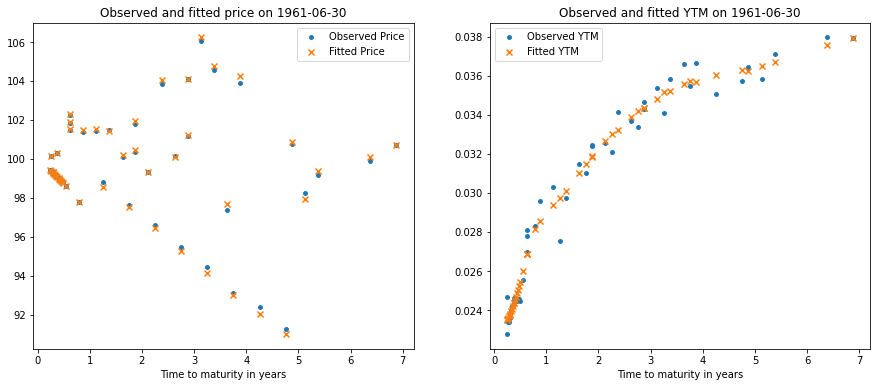

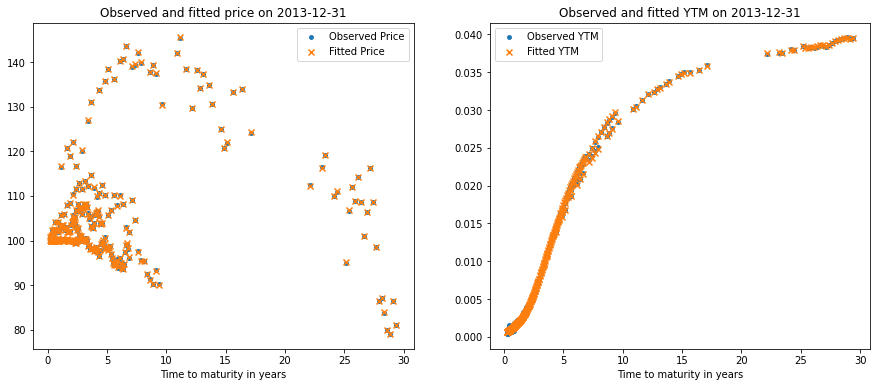

In [8]:
for date in example_dates:
    
    # load price vector and cashflow matrix
    C=dict_data[date]['C']
    M=C.shape[0]
  
    # calculate implied prices by fitted discount curve
    B_fitted=C@dict_fit[date]['g_solved'][:C.shape[1]]

    # get YTM and duration
    ytm_fitted = np.zeros(M) # YTM and duration
    ttm = np.zeros(M) # time to maturity in days
    
    for i in range(M):
        time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
        ytm_fitted[i], _ = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1],
                                                         time_to_cashflow_inday,
                                                         B_fitted[i])
        ttm[i] = max(time_to_cashflow_inday)
        
    
    # plot
    fig=plt.figure(figsize=(15,6))
    ax_1,ax_2=fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)
    

    ax_1.scatter(ttm/365, dict_data[date]['B'], marker='o', s=15, label='Observed Price');
    ax_1.scatter(ttm/365, B_fitted, marker='x', label='Fitted Price');
    
    ax_2.scatter(ttm/365, dict_data[date]['ytm'], marker='o', s=15, label='Observed YTM');
    ax_2.scatter(ttm/365, ytm_fitted, marker='x', label='Fitted YTM');
  

    ax_1.set_title('Observed and fitted price on {}'.format(date));
    ax_2.set_title('Observed and fitted YTM on {}'.format(date));
    
    for ax in [ax_1, ax_2]:
        ax.legend();
        ax.set_xlabel('Time to maturity in years');
    